# Transfer raw data from Greene to cloud bucket
- 1 hour is just not enough given the resources and network, so this does not work with the [temporary token method](https://leap-stc.github.io/guides/hub_guides.html#upload-medium-sized-original-data-from-your-local-machine)
- I am now following the instructions for the [permanent google groups authentication](https://leap-stc.github.io/guides/hub_guides.html#uploading-large-original-data-from-an-hpc-system-no-browser-access-on-the-system-available)
    - Does the conda install on Greene work? Nope, ok so ill try to install it [manually (make sure to use the generic linux instructions)](https://cloud.google.com/sdk/docs/install#linux)
    - FUCKKKKK THIS IS ANNOYING, can't install jack shit on this machine. How did Surya work around this?
- Ok I am totally hacking this and splitting the dataset up in two, and renew the token in between...what a mess.

In [2]:
import glob
import xarray as xr
import numpy as np

directory = '/scratch/aa9537/OM4-5daily/'
files = sorted(glob.glob(f"{directory}*ocean_5daily.nc"))
# grid_path = 
# files
pick_vars = [
 # 'average_DT',
 # 'average_T1',
 # 'average_T2',
 'hfds',
 'so',
 'tauuo',
 'tauvo',
 'thetao',
 'time_bnds',
 'uo',
 'vo',
 'zos'
]

In [3]:
ds = xr.open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    chunks={'time':1},
    combine='nested',
    concat_dim='time', 
)
ds = ds[pick_vars]
ds = ds.rename({'z_l':'lev'})
# cast all variables to lower precision
for var in ds.data_vars:
    if var != 'time_bnds': # this will raise an error later, since cftime obj cannot be cast to float
        ds[var] = ds[var].astype(np.float32)
ds

<xarray.Dataset>
Dimensions:    (time: 4745, yh: 1080, xh: 1440, lev: 19, xq: 1441, yq: 1081,
                nv: 2)
Coordinates:
  * xh         (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh         (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time       (time) object 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * nv         (nv) float64 1.0 2.0
  * lev        (lev) float64 2.5 10.0 22.5 40.0 ... 3.1e+03 4e+03 5e+03 6e+03
  * xq         (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables:
    hfds       (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    so         (time, lev, yh, xh) float32 dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    tauuo      (time, yh, xq) float32 dask.array<chunksize=(1, 1080, 1441), meta=np.ndarray>
    tauvo      (time, yq, xh) float32 dask.array<chunksize=(1, 1081, 1440), meta=np.ndarray>
    thetao     (time, lev, yh, xh) float32 dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    time_bnds  (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    uo         (time, lev, yh, xq) float32 dask.array<chunksize=(1, 19, 1080, 1441), meta=np.ndarray>
    vo         (time, lev, yq, xh) float32 dask.array<chunksize=(1, 19, 1081, 1440), meta=np.ndarray>
    zos        (time, yh, xh) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    title:             OM4p25_5daily_cycle1
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [4]:
ds.nbytes/1e12

2.362372426384

## Testing to remove encoding (it causes issues with the write later for time)
Oh this might be due to the .astype call, but that seems like a bug? Reproduce this for xarray.

In [5]:
import gcsfs
import xarray as xr
from google.cloud import storage
from google.oauth2.credentials import Credentials

In [6]:
from dask.diagnostics import ProgressBar

In [7]:
ds_a = ds.isel(time=slice(0,1500))
ds_b = ds.isel(time=slice(1500, 3000))
ds_c = ds.isel(time=slice(3000, None))

## Part 1

In [8]:
# # import an access token
# # - option 1: read an access token from a file
# with open("token.txt") as f:
#     access_token = f.read().strip()

# # setup a storage client using credentials
# credentials = Credentials(access_token)
# fs = gcsfs.GCSFileSystem(token=credentials)
# mapper = fs.get_mapper('gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr')

In [9]:
# fs.rm(mapper.root, recursive=True);

In [10]:
# ds_write = ds_a
# with ProgressBar():
#     ds_write.to_zarr(mapper, mode='w')

## Part 2 

In [ ]:
(refresh token before running)

In [11]:
# import an access token
# - option 1: read an access token from a file
with open("token.txt") as f:
    access_token = f.read().strip()

# setup a storage client using credentials
credentials = Credentials(access_token)
fs = gcsfs.GCSFileSystem(token=credentials)
mapper = fs.get_mapper('gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr')

In [12]:
ds_write = ds_b
with ProgressBar():
    ds_write.to_zarr(mapper, mode='a', append_dim='time')

[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 920.53 ms
[########################################] | 100% Completed | 47m 13s


## Part 3

In [ ]:
(refresh token before running)

In [13]:
# import an access token
# - option 1: read an access token from a file
with open("token.txt") as f:
    access_token = f.read().strip()

# setup a storage client using credentials
credentials = Credentials(access_token)
fs = gcsfs.GCSFileSystem(token=credentials)
mapper = fs.get_mapper('gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr')

In [14]:
ds_write = ds_c
with ProgressBar():
    ds_write.to_zarr(mapper, mode='a', append_dim='time')

[########################################] | 100% Completed | 101.53 ms
[########################################] | 100% Completed | 1.43 sms
[########################################] | 100% Completed | 54m 5ss


## Testing the output

In [15]:
ds_new = xr.open_dataset(mapper, engine='zarr', use_cftime=True, chunks={})

In [16]:
# xr.testing.assert_equal(ds.isel(time=slice(0,20)), ds_new)

In [17]:
import numpy as np
from dask.diagnostics import ProgressBar
with ProgressBar():
    a = ds_new.isel(time=slice(0, None, 100), lev=0).mean('time').load()

[########################################] | 100% Completed | 9.44 sms


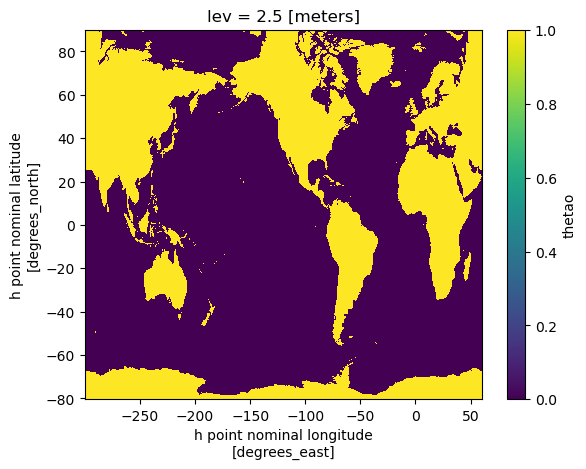

In [22]:
np.isnan(ds_new.isel(time=slice(0, None, 100), lev=0).thetao).any('time').plot()

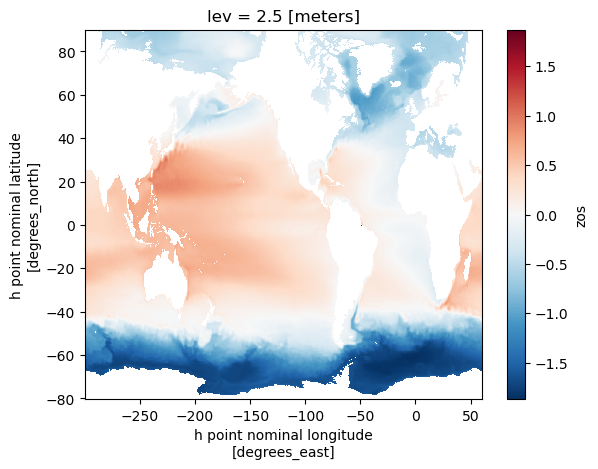

In [18]:
a.zos.plot()

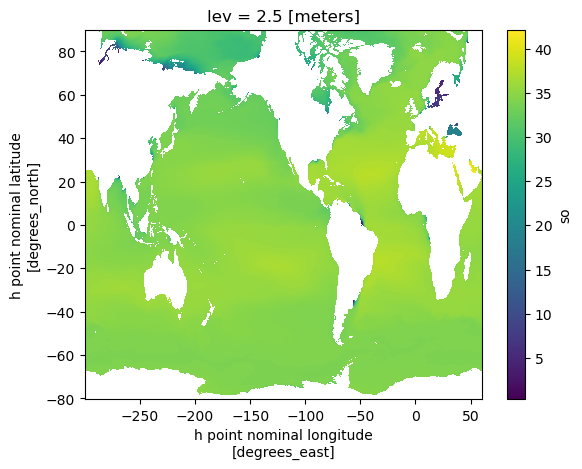

In [19]:
a.so.plot()